In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 1. Load the dataset
df = pd.read_csv('health_data.csv')

In [3]:
# ==========================================
# 2. Data Cleaning & Preprocessing
# ==========================================
print("--- Starting Data Cleaning ---")

# A. Remove Duplicate Rows
# Check for full duplicate rows
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - len(df)} duplicate rows.")

--- Starting Data Cleaning ---
Removed 0 duplicate rows.


In [4]:
# B. Handle Date Formats
# Convert 'ClaimDate' to datetime. 'coerce' turns unparseable data into NaT (Not a Time)
df['ClaimDate'] = pd.to_datetime(df['ClaimDate'], errors='coerce', format='mixed')

# Check if any dates failed to parse
missing_dates = df['ClaimDate'].isna().sum()
if missing_dates > 0:
    print(f"Warning: {missing_dates} rows have invalid dates. Dropping them...")
    df.dropna(subset=['ClaimDate'], inplace=True)

In [5]:
# C. String Sanitization
# Strip leading/trailing whitespace from all string columns (common issue in CSVs)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

In [6]:
# D. Sanity Checks
# Ensure numerical values make sense (e.g., no negative ages or prices)
invalid_ages = df[df['PatientAge'] < 0]
invalid_amounts = df[df['ClaimAmount'] < 0]

if not invalid_ages.empty:
    print(f"Found {len(invalid_ages)} entries with negative age. replacing with NaN.")
    df.loc[df['PatientAge'] < 0, 'PatientAge'] = np.nan

if not invalid_amounts.empty:
    print(f"Found {len(invalid_amounts)} entries with negative claim amount.")

In [7]:
# E. Missing Value Handling (Imputation)
# Although your current data has 0 nulls, this is best practice for future data
if df.isnull().sum().sum() > 0:
    print("Missing values found. Filling numericals with median and categoricals with mode.")
    # Fill numeric NaNs with Median
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col] = df[col].fillna(df[col].median())
    
    # Fill categorical NaNs with Mode (most frequent value)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0])

print("--- Data Cleaning Complete ---\n")

--- Data Cleaning Complete ---



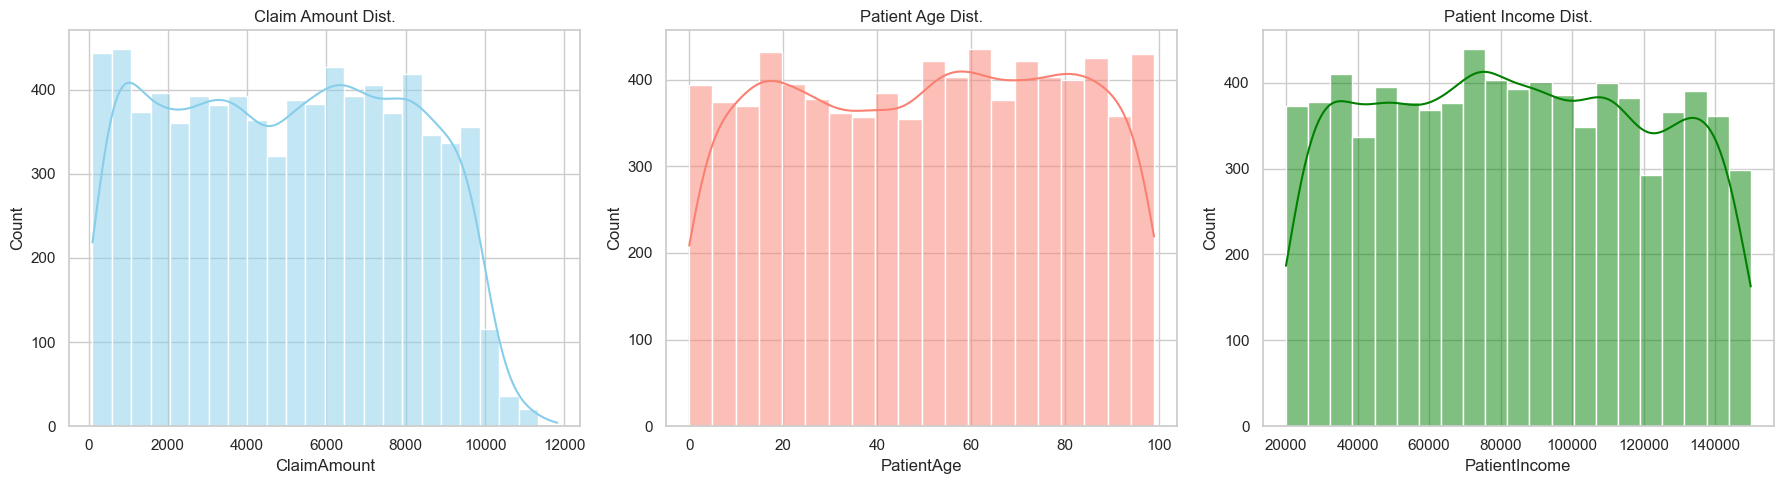

In [8]:
# ==========================================
# 3. Exploratory Data Analysis (EDA)
# ==========================================

# Add MonthYear for Time Series
df['MonthYear'] = df['ClaimDate'].dt.to_period('M')

# Set visual style
sns.set(style="whitegrid")

# --- Visualizations ---

# 1. Numerical Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['ClaimAmount'], kde=True, ax=axes[0], color='skyblue').set_title('Claim Amount Dist.')
sns.histplot(df['PatientAge'], kde=True, ax=axes[1], color='salmon').set_title('Patient Age Dist.')
sns.histplot(df['PatientIncome'], kde=True, ax=axes[2], color='green').set_title('Patient Income Dist.')
plt.tight_layout()
plt.show()

/var/folders/q0/vdgx6p5d34dbjg2vv_pf4ppr0000gn/T/ipykernel_98232/749232086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='PatientGender', data=df, ax=axes[0, 0], palette='pastel').set_title('Gender Distribution')
/var/folders/q0/vdgx6p5d34dbjg2vv_pf4ppr0000gn/T/ipykernel_98232/749232086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ClaimStatus', data=df, ax=axes[0, 1], palette='viridis').set_title('Claim Status')
/var/folders/q0/vdgx6p5d34dbjg2vv_pf4ppr0000gn/T/ipykernel_98232/749232086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effec

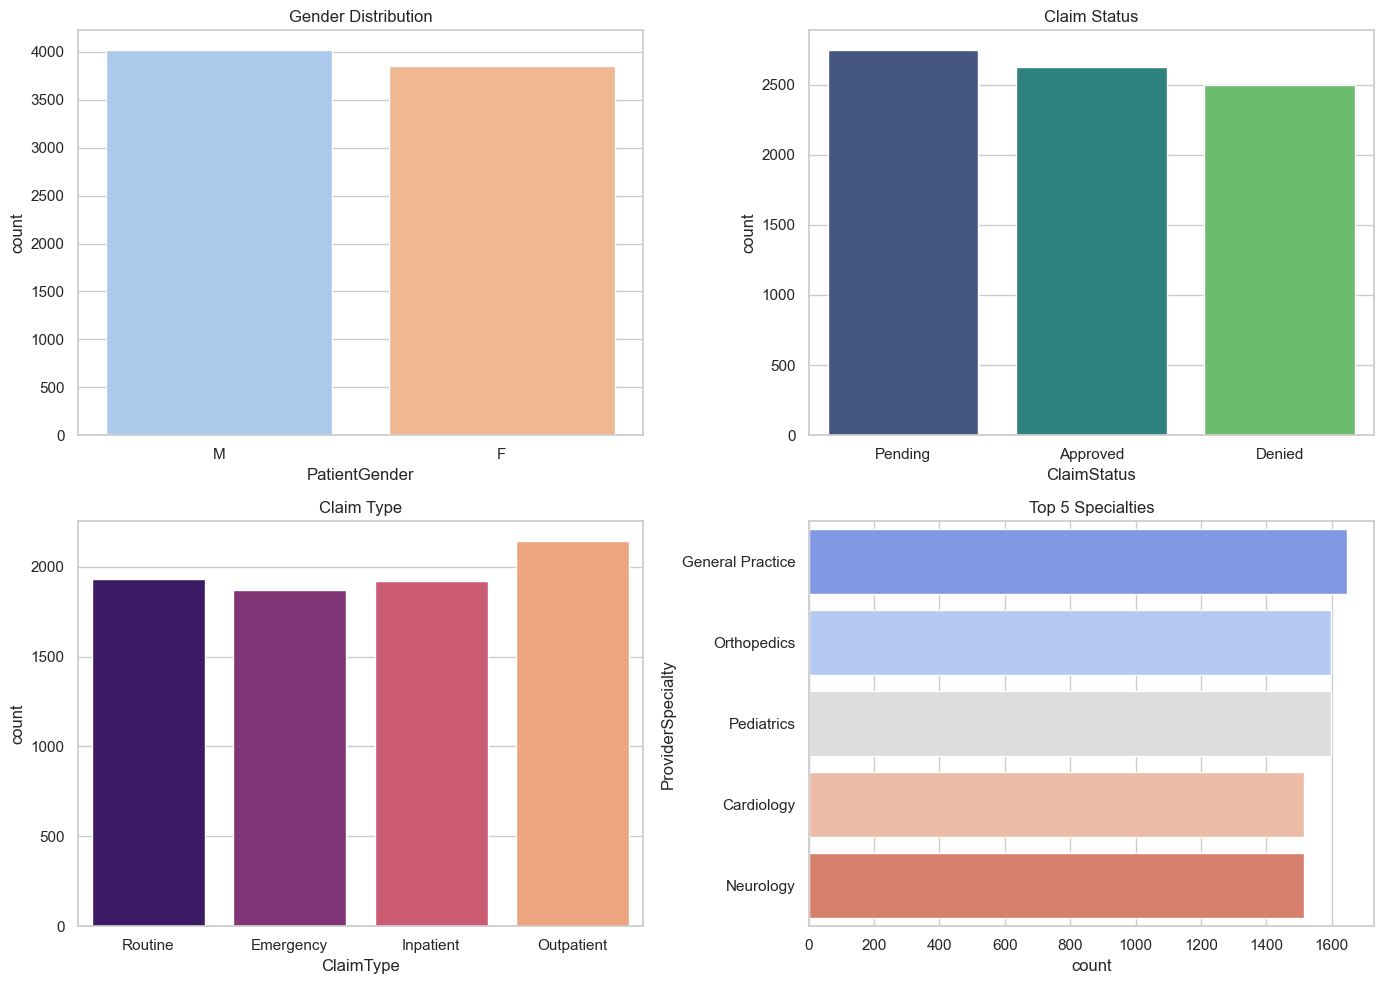

In [9]:
# 2. Categorical Counts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.countplot(x='PatientGender', data=df, ax=axes[0, 0], palette='pastel').set_title('Gender Distribution')
sns.countplot(x='ClaimStatus', data=df, ax=axes[0, 1], palette='viridis').set_title('Claim Status')
sns.countplot(x='ClaimType', data=df, ax=axes[1, 0], palette='magma').set_title('Claim Type')
sns.countplot(y='ProviderSpecialty', data=df, order=df['ProviderSpecialty'].value_counts().iloc[:5].index, ax=axes[1, 1], palette='coolwarm').set_title('Top 5 Specialties')
plt.tight_layout()
plt.show()

/var/folders/q0/vdgx6p5d34dbjg2vv_pf4ppr0000gn/T/ipykernel_98232/3821696628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ClaimStatus', y='ClaimAmount', data=df, palette='Set2')


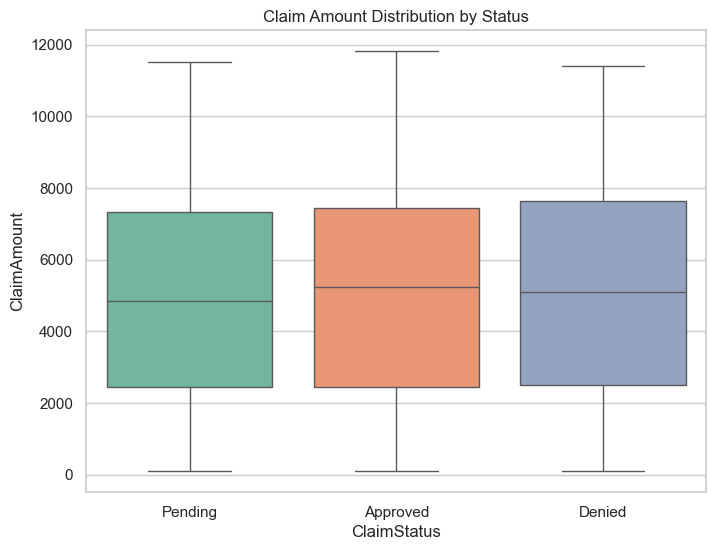

In [10]:
# 3. Bivariate Analysis: Claim Amount by Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='ClaimStatus', y='ClaimAmount', data=df, palette='Set2')
plt.title('Claim Amount Distribution by Status')
plt.show()

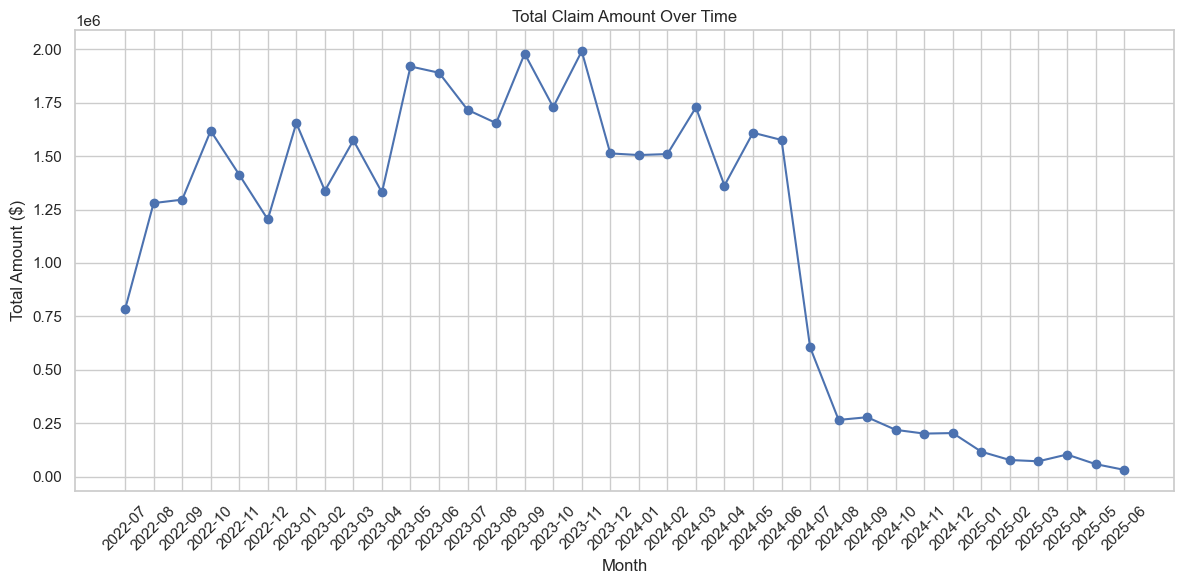

In [11]:
# 4. Time Series Trend
monthly_claims = df.groupby('MonthYear')['ClaimAmount'].sum()
monthly_claims.index = monthly_claims.index.astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_claims.index, monthly_claims.values, marker='o', linestyle='-', color='b')
plt.xticks(rotation=45)
plt.title('Total Claim Amount Over Time')
plt.ylabel('Total Amount ($)')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# --- Summary Stats ---
print("\nTop 5 High Cost Claims:")
df.nlargest(5, 'ClaimAmount')[['ClaimID', 'ClaimAmount']]


Top 5 High Cost Claims:


ClaimID   ClaimAmount
5275  51ce2045-a20b-42d0-b78e-73403ca3b458  11819.115726
5823  f40e2049-a2ff-45bf-b30e-75e32378d1da  11522.270835
5873  d56c7827-1977-4a83-8bf7-463d98fc3c26  11410.806074
4895  62507048-c4f0-4f4d-a97d-f1aba5c45a9e  11239.555772
5393  fd034a96-a1ed-456c-beec-1e20bfae2df9  11232.288414